# Chocolate Rating Analysis

## Web scraping data to then process, clean, etc. in the notebook.

In [1]:
# import warnings
# warnings.filterwarnings('ignore')

# from requests import get
# from bs4 import BeautifulSoup
# import pandas as pd
# from selenium import webdriver
# import chromedriver_autoinstaller
# def create_driver(headless=True):
#     driver = chromedriver_autoinstaller.install(cwd=True)
#     chrome_options = webdriver.ChromeOptions()     
#     if headless:
#         chrome_options.add_argument("--headless")
#         driver = webdriver.Chrome(driver, 
#                               chrome_options = chrome_options)
#         return driver
# driver = create_driver()

In [2]:
# driver.get("http://flavorsofcacao.com/chocolate_database.html")

In [3]:
# div_id = "spryregion1"

# html = driver.page_source
# soup = BeautifulSoup(html)
# div = soup.find('div', {'id':div_id})
# div

# table = div.find('table')
# table


In [4]:
# pd.read_html(str(table))[0]

In [5]:
# df.to_csv('../../../data/chocolate.csv', index=False)

## Importing Necessary Python Libraries 

In [6]:
import pandas as pd 
import numpy as np 
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.impute import SimpleImputer
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import plot_confusion_matrix, auc, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from imblearn.over_sampling import SMOTE

all_data = pd.read_csv('../../../data/chocolate.csv')
all_data.head()

# new data frame with split value columns 


,REF,Company (Manufacturer),Company Location,Review Date,Country of Bean Origin,Specific Bean Origin or Bar Name,Cocoa Percent,Ingredients,Most Memorable Characteristics,Rating
0,2454,5150,U.S.A.,2019,Madagascar,"Bejofo Estate, batch 1",76%,"3- B,S,C","cocoa, blackberry, full body",3.75
1,2458,5150,U.S.A.,2019,Dominican Republic,"Zorzal, batch 1",76%,"3- B,S,C","cocoa, vegetal, savory",3.50
2,2454,5150,U.S.A.,2019,Tanzania,"Kokoa Kamili, batch 1",76%,"3- B,S,C","rich cocoa, fatty, bready",3.25
3,797,A. Morin,France,2012,Peru,Peru,63%,"4- B,S,C,L","fruity, melon, roasty",3.75
4,797,A. Morin,France,2012,Bolivia,Bolivia,70%,"4- B,S,C,L","vegetal, nutty",3.50


## Data Cleaning 

### Replacing column spaces with underscores and lower casing column names for simplicity when calling them. 

In [7]:
all_data.columns = all_data.columns.str.replace(' ', '_').str.replace('(', '').str.replace(')', '').str.lower()

all_data = all_data.replace("%", "", regex=True)
all_data

,ref,company_manufacturer,company_location,review_date,country_of_bean_origin,specific_bean_origin_or_bar_name,cocoa_percent,ingredients,most_memorable_characteristics,rating
0,2454,5150,U.S.A.,2019,Madagascar,"Bejofo Estate, batch 1",76,"3- B,S,C","cocoa, blackberry, full body",3.75
1,2458,5150,U.S.A.,2019,Dominican Republic,"Zorzal, batch 1",76,"3- B,S,C","cocoa, vegetal, savory",3.50
2,2454,5150,U.S.A.,2019,Tanzania,"Kokoa Kamili, batch 1",76,"3- B,S,C","rich cocoa, fatty, bready",3.25
3,797,A. Morin,France,2012,Peru,Peru,63,"4- B,S,C,L","fruity, melon, roasty",3.75
4,797,A. Morin,France,2012,Bolivia,Bolivia,70,"4- B,S,C,L","vegetal, nutty",3.50
...,...,...,...,...,...,...,...,...,...,...
2357,1205,Zotter,Austria,2014,Blend,Raw,80,"4- B,S*,C,Sa","waxy, cloying, vegetal",2.75
2358,1996,Zotter,Austria,2017,Colombia,"APROCAFA, Acandi",75,"3- B,S,C","strong nutty, marshmallow",3.75
2359,2170,Zotter,Austria,2018,Belize,Maya Mtn,72,"3- B,S,C","muted, roasty, accessible",3.50
2360,2170,Zotter,Austria,2018,Congo,Mountains of the Moon,70,"3- B,S,C","fatty, mild nuts, mild fruit",3.25


In [8]:
df.company_manufacturer.nunique()

NameError: name 'df' is not defined

In [9]:
df =  all_data.copy()

In [10]:
# retreiving rows from the third index and on - leaving out rows with empty values
df['ingredient_list'] = [np.nan if l is np.nan else l[3:] for l in df['ingredients']]

In [11]:
df['ingredient_list'].value_counts()

B,S,C          903
B,S            661
B,S,C,L        273
B,S,C,V,L      184
B,S,C,V        139
B,S*            31
B,S*,C,Sa       20
B,S*,C          12
B,S,L            8
B,S*,C,V         7
,S,C,V,Sa        6
B,S,C,Sa         5
B,S,V,L          5
B                5
,S,C,V,L,Sa      4
B,S,V            3
B,S*,V,L         3
B,S*,C,L         2
B,S*,Sa          1
B,S,C,L,Sa       1
B,C              1
Name: ingredient_list, dtype: int64

In [12]:
# leaving out occurances below 8 

most_common = (df['ingredient_list'].value_counts()).iloc[:9].index


df = df[df['ingredient_list'].isin(most_common)]

### Clarifying important predictor values (x) for the target value (y).

In [13]:
features = df.drop(['rating',  'ingredients', 'review_date', 'ref'], axis =1)
X = features
y = df.rating



### Splitting the data into three subsets of training and validation data for the future models.
    Two train test splits create three subsets of the original dataset which allows for the training data to not be bled into the test data - this reduced model's bias towards the pre-existing testing data, thus assuring maximum performance on future test sets which the model has never been exposed. 

In [14]:
#performing train test split for test set (subsets 1/3)
X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=.15, random_state=42)


#performing a train test split for train and validation set (subsets - 3/3)
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, test_size=.15, random_state=42) 

In [15]:
#checking to ensure the shape of the columns and rows are still the same for the X and y values after the train test split.
X_tr.shape, y_tr.shape

((1896, 7), (1896,))

### Replacing any existing missing values  

In [16]:
#ingredients have 88 rows that have no imputs.
df.isna().sum()

ref                                 0
company_manufacturer                0
company_location                    0
review_date                         0
country_of_bean_origin              0
specific_bean_origin_or_bar_name    0
cocoa_percent                       0
ingredients                         0
most_memorable_characteristics      0
rating                              0
ingredient_list                     0
dtype: int64

In [17]:
# the empty value replacement will be done using the 
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

In [18]:
imputer.fit(X_train)

SimpleImputer(strategy='most_frequent')

In [19]:
X_train_imputed = pd.DataFrame(imputer.transform(X_train), columns=X.columns)
X_val_imputed = pd.DataFrame(imputer.transform(X_val), columns=X.columns)

In [20]:
print("X_train missing: ", X_train_imputed.isna().sum().sum())
print('X_val missing: ', X_val_imputed.isna().sum().sum())

X_train missing:  0
X_val missing:  0


In [21]:
# WHY DO WE USE  X INSTEAD OF X_TRAIN  

In [22]:
#num_cols_train = list(X.select_dtypes('number').columns)
#num_cols_train

In [23]:
cat_cols_train = list(X.select_dtypes('object').columns)
cat_cols_train

['company_manufacturer',
 'company_location',
 'country_of_bean_origin',
 'specific_bean_origin_or_bar_name',
 'cocoa_percent',
 'most_memorable_characteristics',
 'ingredient_list']

In [24]:
#num_cols_val = list(X.select_dtypes('number').columns)
#num_cols_val

In [25]:
cat_cols_val = list(X.select_dtypes('object').columns)
cat_cols_val

['company_manufacturer',
 'company_location',
 'country_of_bean_origin',
 'specific_bean_origin_or_bar_name',
 'cocoa_percent',
 'most_memorable_characteristics',
 'ingredient_list']

In [26]:
# Instantiate StandardScaler
scaler = StandardScaler()

In [27]:
# fit on Imputed training data with numeric columns in train
#scaler.fit(X_train_imputed[num_cols_train])

In [28]:
# fit on Imputed training data with numeric  columns in val
#scaler.fit(X_train_imputed[num_cols_val])

In [29]:
# transform training and validation data
#X_train_scaled = pd.DataFrame(scaler.transform(X_train_imputed[num_cols_train]), columns=num_cols)
#X_val_scaled = pd.DataFrame(scaler.transform(X_val_imputed[num_cols_val]), columns=num_cols)

In [30]:
#X_train_scaled

In [31]:
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')

In [95]:
# fit on training categorical data
ohe.fit(X_train_imputed[['ingredient_list']])


X_train_encoded = ohe.transform(X_train_imputed[['ingredient_list']])
X_val_encoded = ohe.transform(X_val_imputed[['ingredient_list']])

X_val_encoded_df= pd.DataFrame(X_val_encoded, columns=ohe.get_feature_names())

X_val_encoded_df

,"x0_B,S","x0_B,S*","x0_B,S*,C","x0_B,S*,C,Sa","x0_B,S,C","x0_B,S,C,L","x0_B,S,C,V","x0_B,S,C,V,L","x0_B,S,L"
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
280,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
281,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
282,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
283,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [100]:
X_val_df = pd.concat([X_val, X_train_encoded_df],axis=1)
X_val_df.isna().sum()

company_manufacturer                1411
company_location                    1411
country_of_bean_origin              1411
specific_bean_origin_or_bar_name    1411
cocoa_percent                       1411
                                    ... 
x6_B,S,C                              85
x6_B,S,C,L                            85
x6_B,S,C,V                            85
x6_B,S,C,V,L                          85
x6_B,S,L                              85
Length: 840, dtype: int64

In [101]:
# fit on training categorical data
ohe.fit(X_train_imputed[cat_cols_train])

OneHotEncoder(handle_unknown='ignore', sparse=False)

In [34]:
# fit on validation categorical data
ohe.fit(X_val_imputed[cat_cols_val])

OneHotEncoder(handle_unknown='ignore', sparse=False)

In [36]:
# transform training and validation data
X_train_encoded = ohe.transform(X_train_imputed[cat_cols_train], )
X_val_encoded = ohe.transform(X_val_imputed[cat_cols_val])

In [37]:
X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=ohe.get_feature_names())
X_val_encoded_df = pd.DataFrame(X_val_encoded, columns=ohe.get_feature_names())
X_train_encoded_df

,x0_A. Morin,x0_Aelan,x0_Aequare (Gianduja),x0_Altus aka Cao Artisan,x0_Amano,x0_Amazona,x0_Ambrosia,x0_Amedei,x0_Anahata,x0_Ara,...,"x5_woody, toast, pepper","x6_B,S","x6_B,S*","x6_B,S*,C","x6_B,S*,C,Sa","x6_B,S,C","x6_B,S,C,L","x6_B,S,C,V","x6_B,S,C,V,L","x6_B,S,L"
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1606,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1607,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1608,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1609,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [38]:
X_train_encoded_df.loc[:].sum()

x0_A. Morin                  18.0
x0_Aelan                      3.0
x0_Aequare (Gianduja)         1.0
x0_Altus aka Cao Artisan      9.0
x0_Amano                      4.0
                            ...  
x6_B,S,C                    656.0
x6_B,S,C,L                  212.0
x6_B,S,C,V                  102.0
x6_B,S,C,V,L                136.0
x6_B,S,L                      5.0
Length: 833, dtype: float64

In [39]:
X_train_df = pd.concat([X_train_scaled, X_train_encoded_df], axis=1)
X_val_df = pd.concat([X_val_scaled, X_val_encoded_df], axis=1)

NameError: name 'X_train_scaled' is not defined

In [40]:
X_train_df.shape

NameError: name 'X_train_df' is not defined

In [41]:
X_val_df.shape

NameError: name 'X_val_df' is not defined

In [ ]:
df

## Preprocessing:

In [67]:
average_ratings_company_location = df.groupby('company_location')['rating'].mean().sort_values().to_dict()

In [68]:
company_location_counts = df['company_location'].value_counts(normalize=True).to_dict()

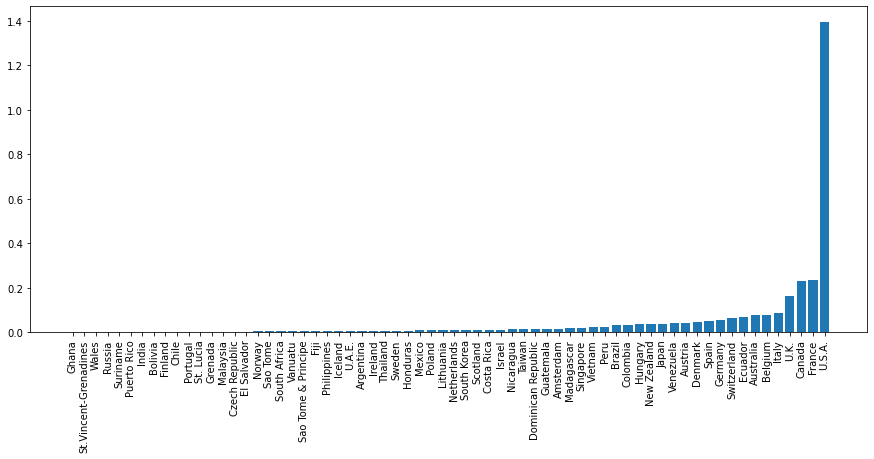

In [69]:
import matplotlib.pyplot as plt
companies_loc = df.company_location.unique()
weighted_rating = []
for company in companies_loc:
    count = company_location_counts[company]
    rating = average_ratings_company_location[company]
    weighted_rating.append(count * rating)
sorted_vals = sorted(list(zip(weighted_rating, companies_loc)))
x = [val[1] for val in sorted_vals]
y = [val[0] for val in sorted_vals]
plt.figure(figsize=(15,6))
plt.bar(x, y)
plt.xticks(rotation=90);

In [70]:
first_bin = x[:47]

In [71]:
df['comp_location_bin'] = 1
bin_a_index = df[df.company_location.isin(first_bin)].index
df.at[bin_a_index, 'comp_location_bin'] = 'a'

In [72]:
idx = x.index('Italy') + 1
second_bin = x[47:idx]
bin_b_index = df[df.company_location.isin(second_bin)].index
df.at[bin_b_index, 'comp_location_bin'] = 'b'

In [73]:
#create a column for every value that could be  in memorable characteristics 
#for loop 

# for ingredient in most_memorable_characteristics:
    

np.unique(df['most_memorable_characteristics'].apply(lambda x: x.split(',')).values)

array([list(['Easter candy', ' burnt']), list(['Fruity', ' Roasty']),
       list(['XL nibs', ' sour', ' cardboard']), ...,
       list(['woody', ' toast', ' pepper']), list(['yellow fruit']),
       list(['yogurt', ' lemon', ' licorice'])], dtype=object)

In [74]:

average_ratings_company_location = df.groupby('most_memorable_characteristics')['rating'].mean().sort_values().to_dict()

company_location_counts = df['most_memorable_characteristics'].value_counts(normalize=True).to_dict()

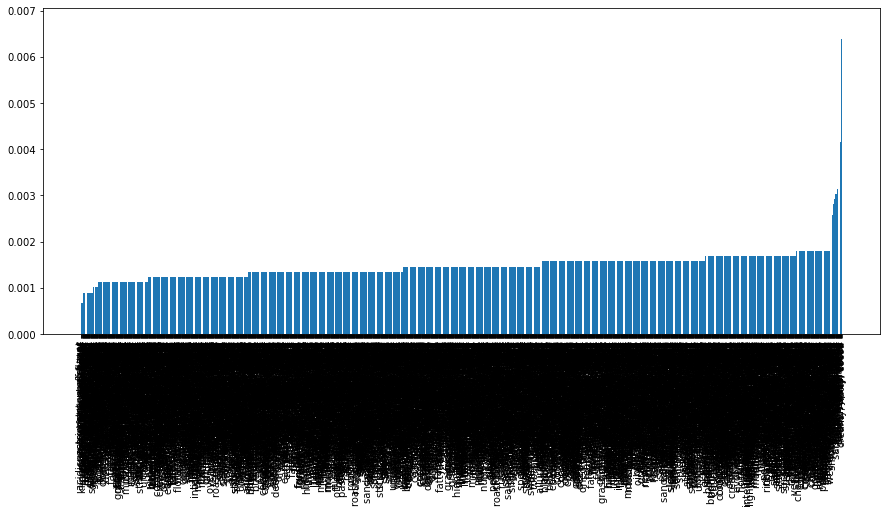

In [75]:
import matplotlib.pyplot as plt
companies_loc = df.most_memorable_characteristics.unique()
weighted_rating = []
for company in companies_loc:
    count = company_location_counts[company]
    rating = average_ratings_company_location[company]
    weighted_rating.append(count * rating)
sorted_vals = sorted(list(zip(weighted_rating, companies_loc)))
x = [val[1] for val in sorted_vals]
y = [val[0] for val in sorted_vals]

plt.figure(figsize=(15,6))
plt.bar(x, y)
plt.xticks(rotation=90);

In [76]:
average_ratings_company_manufacturer = df.groupby('company_manufacturer')['rating'].mean().sort_values().to_dict()

In [77]:
company_manufacturer_counts = df['company_manufacturer'].value_counts(normalize=True).to_dict()

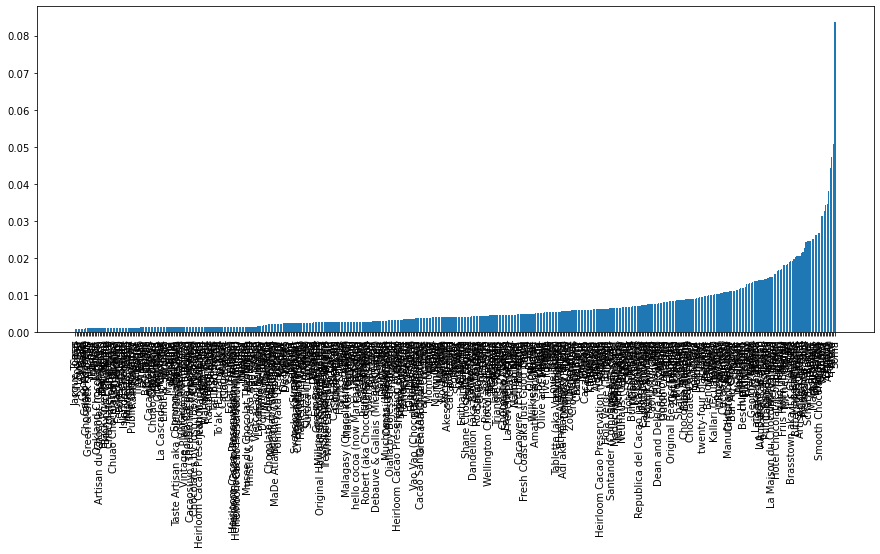

In [78]:
import matplotlib.pyplot as plt
manufacturer_loc = df.company_manufacturer.unique()
weighted_rating = []
for manufacturer in manufacturer_loc:
    count = company_manufacturer_counts[manufacturer]
    rating = average_ratings_company_manufacturer[manufacturer]
    weighted_rating.append(count * rating)
sorted_vals = sorted(list(zip(weighted_rating, manufacturer_loc)))
x = [val[1] for val in sorted_vals]
y = [val[0] for val in sorted_vals]
plt.figure(figsize=(15,6))
plt.bar(x, y)
plt.xticks(rotation=90);

In [79]:
df.comp_manufacturer_bin.index

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            2352, 2353, 2354, 2355, 2356, 2357, 2358, 2359, 2360, 2361],
           dtype='int64', length=2231)

In [80]:
first_bin = x[:500]
df['comp_manufactuer_bin'] = 1

bin_a_index = df[df.company_manufacturer.isin(first_bin)].index
df.at[bin_a_index, 'comp_manufacturer_bin'] = 'a'

In [56]:
second_bin = x[501:1000]
bin_b_index = df[df.company_manufacturer.isin(second_bin)].index
df.at[bin_b_index, 'comp_manufacturer_bin'] = 'b'

In [57]:
second_bin = x[1001:1500]
bin_b_index = df[df.company_manufacturer.isin(second_bin)].index
df.at[bin_b_index, 'comp_manufacturer_bin'] = 'c'

In [58]:
second_bin = x[1501:2000]
bin_b_index = df[df.company_manufacturer.isin(second_bin)].index
df.at[bin_b_index, 'comp_manufacturer_bin'] = 'd'

In [59]:
second_bin = x[2001:]
bin_b_index = df[df.company_manufacturer.isin(second_bin)].index
df.at[bin_b_index, 'comp_manufacturer_bin'] = 'e'

<ipython-input-83-dc0be37709ed>:4: DeprecationWarning: This function is deprecated. Please call randint(1, 100 + 1) instead
  x = np.random.random_integers(1, 100, 5)


ValueError: 'b' is not a valid estimator for `bins`

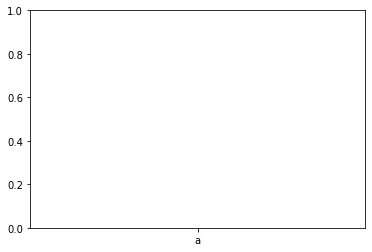

In [83]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
x = np.random.random_integers(1, 100, 5)
plt.hist('a', 'b', 'c', 'd', 'e', bins=5)
plt.ylabel('No of times')
plt.show()

In [ ]:

x = orderedrtandgross.worldwide_gross
df = pd.DataFrame({"x":x})
fig, ax = plt.subplots(figsize=(15,6))
bins= [0,500,1000, 1500, 2000, 2500]
plt.hist(df.values, bins=bins, edgecolor="k")
plt.xticks(bins)
plt.xlabel('World Wide Gross in Millions of Dollars')
plt.ylabel('Number of Movies ')
ax.set_title("World Wide Gross", fontsize=18)

plt.show()